In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

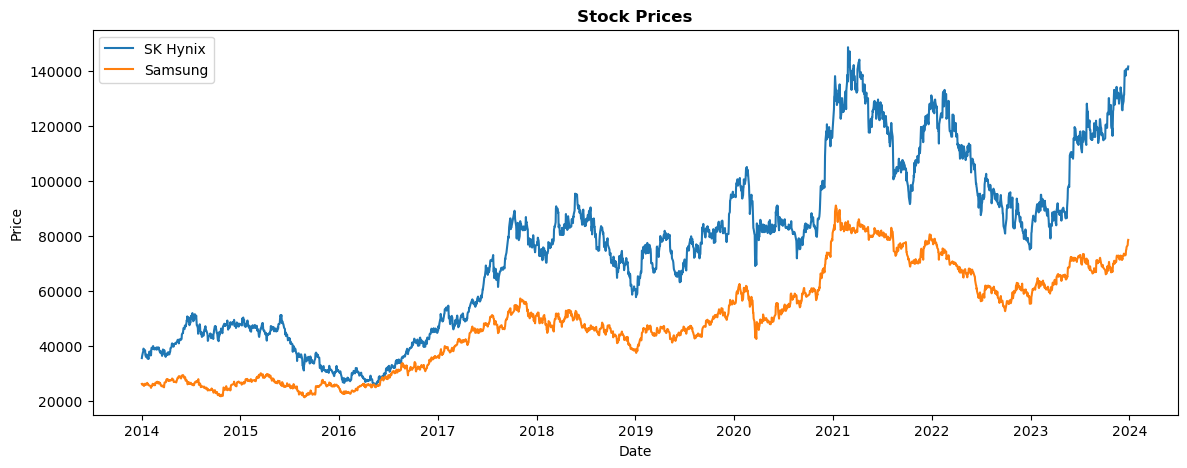

In [3]:
start_date = '2014-01-01'
end_date = '2024-01-01'

# 예시 데이터를 사용하여 SK하이닉스 및 삼성 주가 데이터를 로드합니다.
sk_hynix_data = yf.download('000660.KS', start=start_date, end=end_date, progress=False)
samsung_data = yf.download('005930.KS', start=start_date, end=end_date, progress=False)

sk_hynix_data = sk_hynix_data[['Close']]
samsung_data = samsung_data[['Close']]

# 데이터 시각화
plt.figure(figsize=(14,5))
plt.plot(sk_hynix_data, label='SK Hynix')
plt.plot(samsung_data, label='Samsung')
plt.title('Stock Prices', fontdict={'fontweight': 'bold', 'fontsize': 12})
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [5]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sk_hynix = scaler.fit_transform(sk_hynix_data)
scaled_samsung = scaler.fit_transform(samsung_data)

# 시계열 데이터셋 생성 함수
def create_dataset(X, y, time_step=1):
    dataX, dataY = [], []
    for i in range(len(X)-time_step-1):
        a = X[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(y[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X, y = create_dataset(scaled_sk_hynix, scaled_samsung, time_step)

# 데이터를 학습 및 테스트 세트로 분리
train_size = int(len(X) * 0.65)
test_size = len(X) - train_size

X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# LSTM 입력 형식에 맞게 데이터 형태 변환
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [6]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [7]:
epochs = 1000

for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(torch.FloatTensor(seq))

        single_loss = loss_function(y_pred, torch.FloatTensor([labels]))
        single_loss.backward()
        optimizer.step()

    if i%100 == 0:
        print(f'Epoch {i} loss: {single_loss.item()}')


Epoch 0 loss: 0.001968082971870899
Epoch 100 loss: 0.0001108525539166294
Epoch 200 loss: 0.001044510630890727
Epoch 300 loss: 0.000519377994351089
Epoch 400 loss: 0.0009542116313241422
Epoch 500 loss: 0.0003434894315432757
Epoch 600 loss: 8.640730811748654e-05
Epoch 700 loss: 0.0002069989568553865
Epoch 800 loss: 0.00027413846692070365
Epoch 900 loss: 0.001537313568405807


In [8]:
`model = Model()
`model.load_state_dict(torch.load('model_state_dict.pt'))


# 모델 예측
model.eval()

test_inputs = X_train[-time_step:].tolist()
predictions = []

for i in range(len(X_test)):
    seq = torch.FloatTensor(test_inputs[-time_step:])
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
        predictions.append(model(seq.view(-1, 1, 1)).item())
    test_inputs.append(X_test[i].tolist())

# 예측값 역정규화
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [ ]:
torch.save(model.state_dict(), 'model_state_dict.pt')

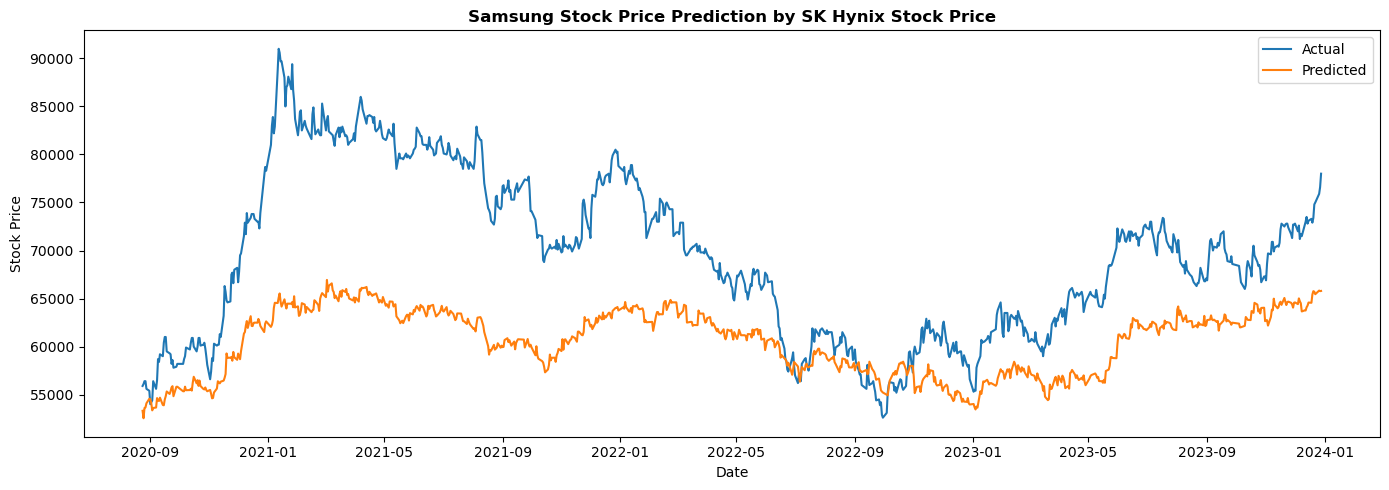

In [9]:
# 실제값과 예측값 비교
plt.figure(figsize=(14,5))
plt.plot(samsung_data.index[len(samsung_data) - len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual')
plt.plot(samsung_data.index[len(samsung_data) - len(y_test):], predictions, label='Predicted')
plt.title('Samsung Stock Price Prediction by SK Hynix Stock Price', fontdict={'fontweight': 'bold', 'fontsize': 12})
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
predictions_df = pd.DataFrame(predictions, index=samsung_data.index[len(samsung_data) - len(y_test):], columns=['Predicted'])
predictions_df['diff'] = predictions_df.diff()
actual_df = pd.DataFrame(scaler.inverse_transform(y_test.reshape(-1, 1)), index=samsung_data.index[len(samsung_data) - len(y_test):], columns=['Actual'])
actual_df['diff'] = actual_df.diff()

predictions_df = predictions_df.drop(predictions_df.index[0])
actual_df = actual_df.drop(actual_df.index[0])
# print(predictions_df.head(2))
# print(actual_df.head(2))
# print(predictions_df.tail(2))
# print(actual_df.tail(2))

sign = -1
boundary = [[(predictions_df['diff'].index[0], -1)], [(actual_df['diff'].index[0], 1)], []]
for i in range(1,len(predictions_df['diff'])):
    if (predictions_df['diff'].iloc[i] > 0 and sign == -1):
        sign = 1
        boundary[0].append((predictions_df['diff'].index[i], sign))
    elif (predictions_df['diff'].iloc[i] < 0 and sign == 1):
        sign = -1
        boundary[0].append((predictions_df['diff'].index[i], sign))

sign = 1
for i in range(1,len(actual_df['diff'])):
    if (actual_df['diff'].iloc[i] > 0 and sign == -1):
        sign = 1
        boundary[1].append((actual_df['diff'].index[i], sign))
    elif (actual_df['diff'].iloc[i] < 0 and sign == 1):
        sign = -1
        boundary[1].append((actual_df['diff'].index[i], sign))
# print(boundary[0][-1])

for i in range(len(predictions_df['diff'])-1):
    if predictions_df.iloc[i, 1] * actual_df.iloc[i, 1] > 0:
        boundary[2].append((predictions_df.index[i], 1))
    else:
        boundary[2].append((predictions_df.index[i], -1))

# print(boundary[2][-1])



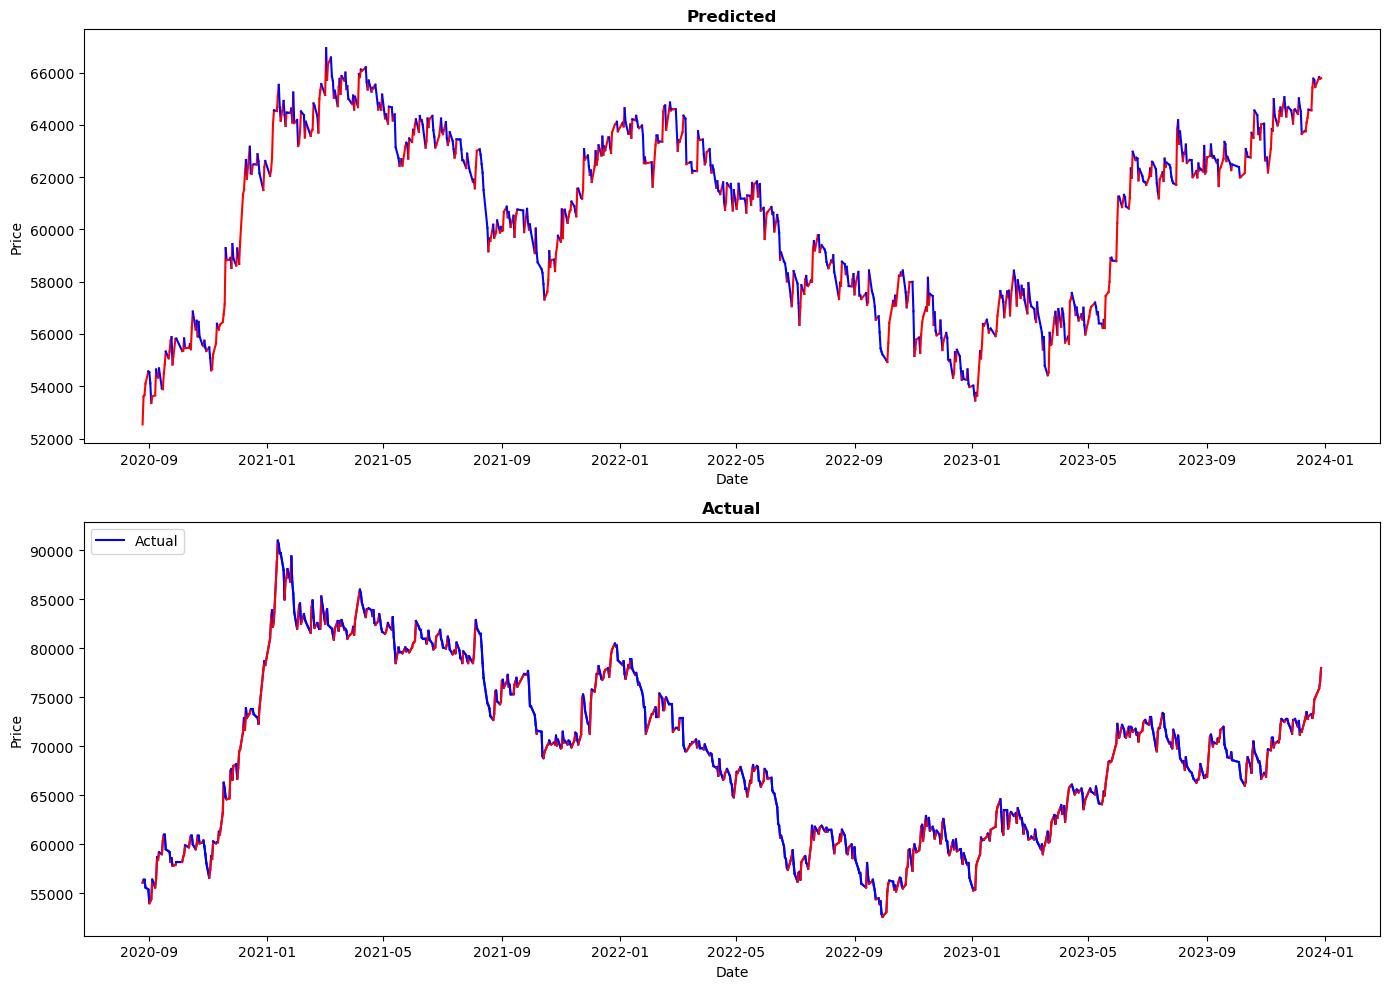

In [32]:
fig, axs = plt.subplots(2,1, figsize=(14,10))
# axs[0].plot(predictions_df['Predicted'], label='Predicted', color='r')
for i in range(len(predictions_df)-1):
    if predictions_df.iloc[i+1, 1] > 0:
        axs[0].plot(predictions_df.iloc[i:i+2, 0], color='r')
    else:
        axs[0].plot(predictions_df.iloc[i:i+2, 0], color='b')
# for i in range(len(boundary[0])-1):
#     if boundary[0][i][1] == 1:
#         axs[0].axvspan(boundary[0][i][0], boundary[0][i+1][0], color='g', alpha=0.4, linewidth=0, hatch='///')
#     else:
#         axs[0].axvspan(boundary[0][i][0], boundary[0][i+1][0], color='r', alpha=0.4, linewidth=0, hatch='///')
# axs[0].axvspan(boundary[0][-1][0], predictions_df['diff'].index[-1], color='r', alpha=0.4, linewidth=0, hatch='///')
axs[0].set_title('Predicted', fontdict={'fontweight': 'bold', 'fontsize': 12})
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
# axs[0].legend()

axs[1].plot(actual_df['Actual'], label='Actual', color='b')
# for i in range(len(boundary[1])-1):
#     if boundary[1][i][1] == 1:
#         axs[1].axvspan(boundary[1][i][0], boundary[1][i+1][0], color='g', alpha=0.4, linewidth=0, hatch='///')
#     else:
#         axs[1].axvspan(boundary[1][i][0], boundary[1][i+1][0], color='r', alpha=0.4, linewidth=0, hatch='///')
# axs[1].axvspan(boundary[1][-1][0], actual_df['diff'].index[-1], color='g', alpha=0.4, linewidth=0, hatch='///')
for i in range(len(actual_df)-1):
    if actual_df.iloc[i+1, 1] > 0:
        axs[1].plot(actual_df.iloc[i:i+2, 0], color='r')
    else:
        axs[1].plot(actual_df.iloc[i:i+2, 0], color='b')
axs[1].set_title('Actual', fontdict={'fontweight': 'bold', 'fontsize': 12})
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
axs[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [33]:
check = pd.DataFrame(columns=['correct', 'wrong'], index=predictions_df.index)
cnt = 0
# print(check.head())
for i in range(len(boundary[2])):
    if boundary[2][i][1] == 1:
        check.iloc[i, 0] = 1
        cnt += 1
    else:
        check.iloc[i, 1] = -1

# print(check.head())

predict_revenue = actual_df.iloc[0, 0]
tmp_predict = 0
actual_revenue = actual_df.iloc[0, 0]
tmp_actual = 0

flag_p = 0
flag_a = 0
minus_ctn = 0
for i in range(1, len(predictions_df)-1):
    if predictions_df.iloc[i, 1] <= 0 and predictions_df.iloc[i+1, 1] >= 0:
        predict_revenue -= actual_df.iloc[i, 0]
        flag_p = 1
        if predict_revenue < 0:
            minus_ctn += 1
    elif predictions_df.iloc[i+1, 1] <= 0 and predictions_df.iloc[i, 1] >= 0:
        predict_revenue += actual_df.iloc[i, 0]
        tmp_predict = predict_revenue
        flag_p = 0
    
    if actual_df.iloc[i, 1] <= 0 and actual_df.iloc[i+1, 1] >= 0:
        actual_revenue -= actual_df.iloc[i, 0]
        flag_a = 1
    elif actual_df.iloc[i, 1] <= 0 and actual_df.iloc[i, 1] >= 0:
        actual_revenue += actual_df.iloc[i, 0]
        tmp_actual = actual_revenue
        flag_a = 0

if flag_p:
    predict_revenue = tmp_predict

if flag_a:
    actual_revenue = tmp_actual

In [ ]:
fig = plt.figure(10, 10)
plt.piechart